In [119]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
np.random.seed(1000)

In [2]:
#reading the data
file = "C:/Users/USERID/Documents/GitHub/Employment2030/Employment2030/tables/scores_answers.csv"

data = pd.read_csv(file,index_col=['noc','workshop.number'])
data.sort_index(inplace=True)
data.loc[data.share == 'remain constant','share'] = 'constant'
data.dropna(inplace=True)

In [3]:
#splitting up x and y
x = data.drop(['absolute','share','Unnamed: 0','noc_code'],axis=1) #making x data frame
x['work_num'] = x.index.get_level_values(1) #making workshop number a variable as well as an index
x.drop_duplicates(inplace=True)
x = np.round(x).astype(int)#round x to make discrete

#creating y variables
y_abs = pd.DataFrame(data['absolute']).pivot_table(index = ['noc','workshop.number'], columns = 'absolute', aggfunc = len).fillna(0)
y_abs['sum'] = y_abs.sum(axis = 1)
y_abs['not_increase'] = y_abs['fewer'] + y_abs['same']
y_abs.loc[:,y_abs.columns!='sum'] = y_abs.loc[:,y_abs.columns!='sum'].divide(y_abs['sum'],axis=0)
y_abs['y'] = y_abs[['fewer','more','same']].idxmax(axis=1)
y_abs['binned_y'] = y_abs[['more','not_increase']].idxmax(axis=1)

y_share = pd.DataFrame(data['share']).pivot_table(index = ['noc','workshop.number'], columns = 'share', aggfunc = len).fillna(0)
y_share['sum'] = y_share.sum(axis = 1)
y_share['not_increase'] = y_share['decrease'] + y_share['constant']
y_share.loc[:,y_share.columns!='sum'] = y_share.loc[:,y_share.columns!='sum'].divide(y_share['sum'],axis=0)
y_share['y'] = y_share[['constant','decrease','increase']].idxmax(axis=1)
y_share['binned_y'] = y_share[['increase','not_increase']].idxmax(axis=1)

In [4]:
#splitting up into random training and validation sets. We have decided to just use the whole data set with kfold validation 
#because of how little data there is. Going to leave this code here in case we change our mind
train_set = np.random.choice(x.index,size=int(len(x.index)*0.8),replace=False)
test_set = np.logical_not(x.index.isin(train_set))

x_train = x.loc[train_set]
x_test = x.loc[test_set]

#full y set for k-fold
y = [y_abs['y'],y_share['y'],
     y_abs['binned_y'],y_share['binned_y'],
     y_abs[['more','same']],y_share[['increase','constant']],
     y_abs['more'],y_share['increase']]

#training and validation y sets if we want to us them
y_train = np.empty(8,dtype = pd.Series)
y_test = np.empty(8,dtype = pd.Series)

for i in range(8):
    y_train[i] = y[i].loc[train_set]
    y_test[i] = y[i].loc[test_set]

ok lets try some models
our y var has 8 binary types that can be combined so there are 8 distinct versions of the y variable. The types are
 - absolute vs share (which answer from the expert we use)
 - binned vs not (whether we make use tertiary answers or bin into binary)
 - categories vs distribution (whether we use regression forests to try and fit answer proportions. Also another   possibillity
is using the probabilities that come from counting tree votes)

TOD0 - make a specific model specific parameter grid for every model? Would do this by looking for edge cases in
chosen paramters and adjusting accordingly 
- try to figure out how to use these premades to make a model that is fitted based on the proportion of trees voting for an outcome

old param grids:
param_grid= {'max_features': np.asarray(range(9,25,2)),#number of features a tree selects
    'n_estimators':[100,150,250,275,300],#number of trees
    'min_samples_leaf': [1,2,4,8],#minimum number of data points can be used to make a leaf at the end of a tree
    'min_samples_split': [5,10,15],#min number of data points to split a branch
    'criterion':['gini','entropy']}#metric to order features for each treet

param_grid_regres= {'max_features': np.asarray(range(9,25,2)),#number of features a tree selects
    'n_estimators':[100,150,250,275,300],#number of trees
    'min_samples_leaf': [1,2,4,8],#minimum number of data points can be used to make a leaf at the end of a tree
    'min_samples_split': [5,10,15],#min number of data points to split a branch
    'criterion':['mse','mae']}#metric to order features for each tree
    
then...

tailored_param_grids = [{'n_estimators':[300,350,400],'min_samples_split': [15,18,21]},
                        {'n_estimators':[125,150,175],'min_samples_split': [8,10,12], 'min_samples_leaf': [8,10,12]},
                        {'n_estimators':[300,350,400],'min_samples_split': [8,10,12]},
                        {'n_estimators':[300,350,400],'min_samples_split': [8,10,12]},
                        {'n_estimators':[300,350,400],'min_samples_split': [8,10,12]},
                        {'n_estimators':[50,75,100],'min_samples_split': [15,18,21], 'min_samples_leaf': [8,10,12]},
                        {'n_estimators':[50,75,100],'min_samples_split': [2,3,5], 'min_samples_leaf': [8,10,12]},
                        {'n_estimators':[50,75,100],'min_samples_split': [2,3,5]},
                        {'n_estimators':[50,75,100],'min_samples_split': [2,3,5]}]
                        
                        
                        tailored_rf = [RandomForestClassifier(criterion = 'gini',max_features=21,min_samples_leaf=4,min_samples_split=18),
               RandomForestClassifier(criterion = 'gini',max_features=23,min_samples_leaf=8,min_samples_split=12),
               RandomForestClassifier(criterion = 'gini',max_features=15,min_samples_leaf=1,min_samples_split=10),
               RandomForestClassifier(criterion = 'gini',max_features=11,min_samples_leaf=4,min_samples_split=12),
               RandomForestRegressor(criterion='mse',max_features=13),
               RandomForestRegressor(criterion='mse',max_features=11),
               RandomForestRegressor(criterion='mse',max_features=11,min_samples_leaf=2),
               RandomForestRegressor(criterion='mse',max_features=15,min_samples_leaf=1)]

tailored_param_grids = [{'n_estimators':[300,325]},
                        {'n_estimators':[150,175,200]},
                        {'n_estimators':[400,450,500]},
                        {'n_estimators':[400,450,500],'min_samples_split': [8,10,12]},
                        {'n_estimators':[350,375],'min_samples_split': [8,10,12]},
                        {'n_estimators':[50,75,100],'min_samples_split': [15,18,21], 'min_samples_leaf': [8,10,12]},
                        {'n_estimators':[50,75,100],'min_samples_split': [2,3,5], 'min_samples_leaf': [8,10,12]},
                        {'n_estimators':[50,75,100],'min_samples_split': [2,3,5]},
                        {'n_estimators':[50,75,100],'min_samples_split': [2,3,5]}]

In [75]:
tailored_rf = [RandomForestClassifier(criterion = 'gini',max_features=21,min_samples_leaf=4,min_samples_split=18,n_estimators=300,n_jobs=-1),
               RandomForestClassifier(criterion = 'gini',max_features=23,min_samples_leaf=8,min_samples_split=12,n_estimators=300,n_jobs=-1),
               RandomForestClassifier(criterion = 'gini',max_features=15,min_samples_leaf=1,min_samples_split=10,n_estimators=300,n_jobs=-1),
               RandomForestClassifier(criterion = 'gini',max_features=11,min_samples_leaf=4,min_samples_split=10,n_estimators=300,n_jobs=-1),
               RandomForestRegressor(criterion='mse',max_features=None,min_samples_leaf=10, min_samples_split=10,n_estimators=300,n_jobs=-1),
               RandomForestRegressor(criterion='mse',max_features=None,min_samples_leaf=10, min_samples_split=15,n_estimators=300,n_jobs=-1),
               RandomForestRegressor(criterion='mse',max_features=None,min_samples_split=10,min_samples_leaf=2,n_estimators=300,n_jobs=-1),
               RandomForestRegressor(criterion='mse',max_features=None,min_samples_leaf=2, min_samples_split=5,n_estimators=300,n_jobs=-1)]

param_grid = [{'max_features':[11,23,120]},{"max_depth":np.append(np.asarray(range(10,110,10)),None)}]

                        
selected_models = np.empty(8,dtype = RandomForestClassifier)
scores = np.zeros(8)
features = np.empty(8, dtype = np.ndarray)

for i in range(8):
    if i<4:
        search = GridSearchCV(tailored_rf[i],param_grid,cv=5,n_jobs=-1,iid=False)
    else:
        search = GridSearchCV(tailored_rf[i],param_grid,scoring=make_scorer(mean_absolute_error),cv=5,n_jobs=-1,iid=False)
    search.fit(x,y[i])
    selected_models[i] = search.best_estimator_ 
    scores[i] = search.best_score_
    features[i] = selected_models[i].feature_importances_    

In [107]:
#testing different numver of trees with the found parameters in the earlier search grid
tailored_rf = [RandomForestClassifier(criterion = 'gini',max_features=21,min_samples_leaf=4,min_samples_split=15,n_estimators=100,n_jobs=-1),
               RandomForestClassifier(criterion = 'gini',max_features=23,min_samples_leaf=8,min_samples_split=10,n_estimators=100,n_jobs=-1),
               RandomForestClassifier(criterion = 'gini',max_features=15,min_samples_leaf=1,min_samples_split=10,n_estimators=100,n_jobs=-1),
               RandomForestClassifier(criterion = 'gini',max_features=11,min_samples_leaf=4,min_samples_split=10,n_estimators=100,n_jobs=-1),
               RandomForestRegressor(criterion='mse',max_features=None,min_samples_leaf=10, min_samples_split=10,n_estimators=100,n_jobs=-1),
               RandomForestRegressor(criterion='mse',max_features=None,min_samples_leaf=10, min_samples_split=15,n_estimators=100,n_jobs=-1),
               RandomForestRegressor(criterion='mse',max_features=None,min_samples_split=10,min_samples_leaf=2,n_estimators=100,n_jobs=-1),
               RandomForestRegressor(criterion='mse',max_features=None,min_samples_leaf=2, min_samples_split=5,n_estimators=100,n_jobs=-1)]

scores = np.zeros((8,40))
features = np.empty(8, dtype = np.ndarray)

for k in range(40):
    for i in range(8):
        rf = tailored_rf[i].set_params(n_estimators=10*(k+1))
        rf.fit(x,y[i])
        if i<4:
            scores[i,k] = np.mean(cross_val_score(rf,x,y[i],cv=5,n_jobs=-1))
        else:
            scores[i,k] = np.mean(cross_val_score(rf,x,y[i],scoring=make_scorer(mean_squared_error),cv=5,n_jobs=-1))
        features[i] = rf.feature_importances_    

In [108]:
acc_by_estimators = pd.DataFrame(scores.T,index=range(100,4100,100))

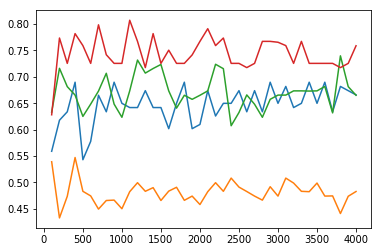

In [109]:
plt.plot(acc_by_estimators.loc[:,0:3])

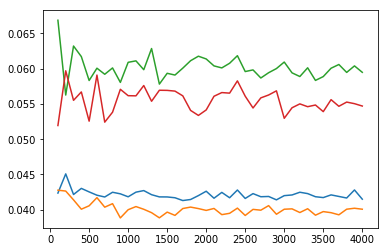

In [110]:
plt.plot(acc_by_estimators.loc[:,4:7])

In [259]:
tailored_rf = [RandomForestClassifier(criterion = 'gini',max_features=21,min_samples_leaf=4,min_samples_split=15,class_weight="balanced",n_estimators=300,n_jobs=-1,),
               RandomForestClassifier(criterion = 'gini',max_features=23,min_samples_leaf=8,min_samples_split=10,class_weight="balanced",n_estimators=300,n_jobs=-1),
               RandomForestClassifier(criterion = 'gini',max_features=15,min_samples_leaf=1,min_samples_split=10,class_weight="balanced",n_estimators=300,n_jobs=-1),
               RandomForestClassifier(criterion = 'gini',max_features=11,min_samples_leaf=4,min_samples_split=10,class_weight="balanced",n_estimators=300,n_jobs=-1),
               RandomForestRegressor(criterion='mse',max_features=None,min_samples_leaf=10, min_samples_split=10,n_estimators=300,n_jobs=-1),
               RandomForestRegressor(criterion='mse',max_features=None,min_samples_leaf=10, min_samples_split=15,n_estimators=300,n_jobs=-1),
               RandomForestRegressor(criterion='mse',max_features=None,min_samples_split=10,min_samples_leaf=2,n_estimators=300,n_jobs=-1),
               RandomForestRegressor(criterion='mse',max_features=None,min_samples_leaf=2, min_samples_split=5,n_estimators=300,n_jobs=-1)]

truth_values_cat = np.empty((120,4),dtype=bool)
truth_values_reg = np.empty((120,4,2),dtype=float)
truth_values_reg_bin = np.empty((120,2),dtype=float)

for i in range(4,8):
    kf = KFold(n_splits=5)
    
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y[i].iloc[train_index], y[i].iloc[test_index]
        prediction = tailored_rf[i].fit(x_train,y_train).predict(x_test)
        if i<4:
            truth_values_cat[test_index,i] = prediction == y_test
        elif i<6:
            truth_values_reg[test_index,i-4] = prediction - y_test
        else:
            truth_values_reg_bin[test_index,i-6] = prediction - y_test

In [282]:
truth_values_cat = pd.DataFrame(truth_values_cat,index=x.index)
truth_values_reg1 = pd.DataFrame(truth_values_reg[:,0,:],index=x.index)
truth_values_reg2 = pd.DataFrame(truth_values_reg[:,1,:],index=x.index)
truth_values_reg_bin = pd.DataFrame(truth_values_reg_bin,index=x.index)

TV_abs = pd.concat([pd.DataFrame(y[0],index=x.index),truth_values_cat[0]],axis=1)
TV_share = pd.concat([pd.DataFrame(y[1],index=x.index),truth_values_cat[1]],axis=1)
TV_abs_bin = pd.concat([pd.DataFrame(y[2],index=x.index),truth_values_cat[2]],axis=1)
TV_share_bin = pd.concat([pd.DataFrame(y[3],index=x.index),truth_values_cat[3]],axis=1)
TV_abs_cont = pd.concat([pd.DataFrame(y[4],index=x.index),truth_values_reg1],axis=1)
TV_share_cont = pd.concat([pd.DataFrame(y[5],index=x.index),truth_values_reg2],axis=1)
TV_abs_cont_bin = pd.concat([pd.DataFrame(y[6],index=x.index),truth_values_reg_bin[0]],axis=1)
TV_share_cont_bin = pd.concat([pd.DataFrame(y[7],index=x.index),truth_values_reg_bin[1]],axis=1)

In [246]:
truth_values_cat.sum()/121

0    0.694215
1    0.561983
2    0.636364
3    0.743802
dtype: float64

In [239]:
TV_abs.groupby(['y']).mean()

,0
y,
fewer,0.729167
more,0.842105
same,0.066667


In [240]:
TV_share.groupby(['y']).mean()

,1
y,
constant,0.321429
decrease,0.654545
increase,0.621622


In [241]:
TV_abs_bin.groupby(['binned_y']).mean()

,2
binned_y,
more,0.682927
not_increase,0.620253


In [242]:
TV_share_bin.groupby(['binned_y']).mean()

,3
binned_y,
increase,0.290323
not_increase,0.910112


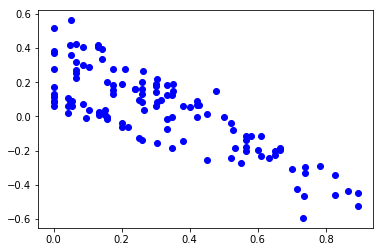

In [297]:
plt.plot(TV_share_cont_bin['increase'],TV_share_cont_bin[1],'bo')

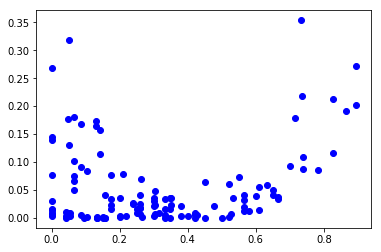

In [298]:
plt.plot(TV_share_cont_bin['increase'],np.square(TV_share_cont_bin[1]),'bo')

In [19]:
feature_grid.iloc[0,:].sort_values( ascending = False)[111:121]

value.Written Comprehension               0.000594
value.Repairing                           0.000569
value.Night Vision                        0.000561
value.Management of Material Resources    0.000500
value.Oral Comprehension                  0.000455
value.Speed of Limb Movement              0.000403
value.Oral Expression                     0.000211
value.Category Flexibility                0.000147
value.Dynamic Flexibility                 0.000000
value.Selective Attention                 0.000000
Name: 0, dtype: float64

In [20]:
feature_grid.iloc[1,:].sort_values( ascending = False)[111:121]

value.Telecommunications                  0.000428
value.Oral Comprehension                  0.000277
value.Oral Expression                     0.000244
value.Food Production                     0.000204
value.Mathematics Knowledge               0.000175
value.Far Vision                          0.000158
value.Dynamic Flexibility                 0.000000
value.Selective Attention                 0.000000
value.Category Flexibility                0.000000
value.Management of Material Resources    0.000000
Name: 1, dtype: float64

In [21]:
feature_grid.iloc[2,:].sort_values( ascending = False)[111:121]

value.Glare Sensitivity         0.001754
value.Written Expression        0.001711
value.Equipment Maintenance     0.001706
value.Oral Expression           0.001578
value.Inductive Reasoning       0.001407
value.Oral Comprehension        0.001282
value.Mathematical Reasoning    0.001121
value.Information Ordering      0.000625
value.Far Vision                0.000484
value.Selective Attention       0.000224
Name: 2, dtype: float64

In [22]:
feature_grid.iloc[3,:].sort_values( ascending = False)[111:121]

value.Sociology and Anthropology          0.001581
value.Problem Sensitivity                 0.001495
value.Management of Material Resources    0.001308
value.Oral Comprehension                  0.001155
value.Inductive Reasoning                 0.001141
value.Oral Expression                     0.001038
value.Telecommunications                  0.000789
value.Far Vision                          0.000635
value.Dynamic Flexibility                 0.000000
value.Selective Attention                 0.000000
Name: 3, dtype: float64

In [23]:
feature_grid.iloc[4,:].sort_values( ascending = False)[111:121]

value.Dynamic Flexibility                  0.0
value.Food Production                      0.0
value.Selective Attention                  0.0
value.Far Vision                           0.0
value.Category Flexibility                 0.0
value.Oral Comprehension                   0.0
value.Management of Material Resources     0.0
value.Repairing                            0.0
value.Management of Financial Resources    0.0
value.Mathematical Reasoning               0.0
Name: 4, dtype: float64

In [24]:
feature_grid.iloc[5,:].sort_values( ascending = False)[111:121]

value.Telecommunications                  0.0
value.Active Listening                    0.0
value.Category Flexibility                0.0
value.Dynamic Flexibility                 0.0
value.Selective Attention                 0.0
value.Gross Body Coordination             0.0
value.Systems Analysis                    0.0
value.Oral Comprehension                  0.0
value.Mathematical Reasoning              0.0
value.Management of Material Resources    0.0
Name: 5, dtype: float64

make pipe in which features are trimmed by a Recursive Feature Evaluation and then inputed into a random forest. Grid search
will be used to select the number of features to be inittially trimed and then max_features for the random forest. This may
well be overkill but it is interesting to see if there is improvement in a tree never seeing certain features. 

currently setting params 
on what we learned in the earlier grid search, but it might be good to grid search in this context
as well

In [25]:
feature_grid.iloc[6,:].sort_values( ascending = False)[111:121]

value.Gross Body Coordination    0.000468
value.Far Vision                 0.000446
value.Oral Comprehension         0.000417
value.Installation               0.000401
value.Extent Flexibility         0.000382
value.Night Vision               0.000299
value.Repairing                  0.000282
value.Active Listening           0.000155
value.Oral Expression            0.000093
value.Selective Attention        0.000000
Name: 6, dtype: float64

In [114]:
rfe_random_forests = [
    RFE(RandomForestClassifier(criterion = 'gini',max_features=21,min_samples_leaf=4,min_samples_split=15,n_estimators=300,n_jobs=-1)),
    RFE(RandomForestClassifier(criterion = 'gini',max_features=23,min_samples_leaf=8,min_samples_split=12,n_estimators=300,n_jobs=-1)),
    RFE(RandomForestClassifier(criterion = 'gini',max_features=15,min_samples_leaf=1,min_samples_split=10,n_estimators=300,n_jobs=-1)),
    RFE(RandomForestClassifier(criterion = 'gini',max_features=11,min_samples_leaf=4,min_samples_split=10,n_estimators=300,n_jobs=-1)),    
    RFE(RandomForestRegressor(criterion='mse',max_features=None,min_samples_split=10,min_samples_leaf=2,n_estimators=300,n_jobs=-1)),
    RFE(RandomForestRegressor(criterion='mse',max_features=None,min_samples_leaf=2, min_samples_split=5,n_estimators=300,n_jobs=-1)),
]
               

param_grid = {'n_features_to_select': np.asarray(range(30,120,10))}

selected_models = np.empty(6,dtype = Pipeline)
scores = np.zeros(6)
features = np.empty(6, dtype = np.ndarray)

for i in range(4,6): 
    if i<4:
        search = GridSearchCV(rfe_random_forests[i],param_grid,cv=5,n_jobs=-1,iid=False)
        search.fit(x,y[i])
    else:
        search = GridSearchCV(rfe_random_forests[i],param_grid,scoring=make_scorer(mean_squared_error),cv=5,n_jobs=-1,iid=False)    
        search.fit(x,y[i+2])
    selected_models[i] = search.best_estimator_ 
    scores[i] = search.best_score_
    features[i] = selected_models[i].get_support()

In [115]:
scores

array([0.        , 0.        , 0.        , 0.        , 0.06092779,
       0.05756447])

In [34]:
selected_models

array([None, None, None, None,
       RFE(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
  n_features_to_select=30, step=1, verbose=0),
       RFE(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
  n_features_to_select=50, step=1, verbose=0)], dtype=object)

In [ ]:
rf =[ 
RandomForestClassifier(criterion = 'gini',max_features=11,min_samples_leaf=4,min_samples_split=10, n_estimators=300,n_jobs=-1),
RandomForestRegressor(criterion='mse',max_features=None,min_samples_leaf=10, min_samples_split=15,n_estimators=300,n_jobs=-1)
]

sfs_rf = [
SFS(estimator = rf[0],k_features=90,forward=False,floating=True,scoring='accuracy',n_jobs=-1),
SFS(estimator = rf[0],k_features=30,forward=False,floating=True,scoring='accuracy',n_jobs=-1),
SFS(estimator = rf[1],k_features=90,forward=False,floating=True,scoring=make_scorer(mean_squared_error),n_jobs=-1),
SFS(estimator = rf[1],k_features=(3,30),forward=True,floating=True,scoring=make_scorer(mean_squared_error),n_jobs=-1)
]


#sfs_rf[0].fit(x,y[3])
sfs_rf[1].fit(x,y[3])
sfs_rf[2].fit(x,y[5])
sfs_rf[3].fit(x,y[5])


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...
STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [305]:
bffs_share_bin_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 28, 31, 32, 36, 38, 42, 46, 48, 69]
bffs_share_features = [2, 4, 9, 15, 17, 20, 22, 23, 26, 29, 31, 34, 38, 41, 42, 43, 44, 56, 58, 60, 67, 71, 75, 77, 96, 98, 101, 105, 106, 107, 113, 119]

In [310]:
x.columns[bffs_share_bin_features]

Index(['value.Active Listening', 'value.Writing', 'value.Speaking',
       'value.Mathematics Skill', 'value.Science', 'value.Critical Thinking',
       'value.Active Learning', 'value.Learning Strategies',
       'value.Monitoring', 'value.Social Perceptiveness', 'value.Negotiation',
       'value.Instructing', 'value.Complex Problem Solving',
       'value.Operations Analysis', 'value.Technology Design',
       'value.Equipment Selection', 'value.Installation', 'value.Programming',
       'value.Operation Monitoring', 'value.Operation and Control',
       'value.Equipment Maintenance', 'value.Judgment and Decision Making',
       'value.Time Management', 'value.Management of Financial Resources',
       'value.Written Comprehension', 'value.Written Expression',
       'value.Deductive Reasoning', 'value.Mathematical Reasoning',
       'value.Memorization', 'value.Trunk Strength'],
      dtype='object')

In [311]:
x.columns[bffs_share_features]

Index(['value.Writing', 'value.Mathematics Skill', 'value.Monitoring',
       'value.Service Orientation', 'value.Operations Analysis',
       'value.Installation', 'value.Operation Monitoring',
       'value.Operation and Control', 'value.Repairing',
       'value.Systems Analysis', 'value.Time Management',
       'value.Management of Personnel Resources', 'value.Written Expression',
       'value.Problem Sensitivity', 'value.Deductive Reasoning',
       'value.Inductive Reasoning', 'value.Information Ordering',
       'value.Arm-Hand Steadiness', 'value.Finger Dexterity',
       'value.Multilimb Coordination', 'value.Explosive Strength',
       'value.Extent Flexibility', 'value.Near Vision',
       'value.Visual Color Discrimination', 'value.Engineering and Technology',
       'value.Building and Construction', 'value.Physics',
       'value.Sociology and Anthropology', 'value.Geography',
       'value.Medicine and Dentistry', 'value.History and Archeology',
       'value.Transporta